In [1]:
import flash as fz
import joblib
import klib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
import yaml
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import (
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path
# from xgboost import XGBClassifier

# Data Assessment and Cleaning

In [2]:
config_path = Path("src/loan_sanction_prediction/config.yaml")
with config_path.open("r") as file:
    config = yaml.safe_load(file)

In [ ]:
# Load the dataset
train_data_path = config["data"]["raw"]["train"]
df = pd.read_csv(train_data_path)
df_bak = df.copy()

In [4]:
# Understand structure of the dataset
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP002244,Male,Yes,0,Graduate,No,2333,2417.0,136.0,360.0,1.0,Urban,Y
1,LP001186,Female,Yes,1,Graduate,Yes,11500,0.0,286.0,360.0,0.0,Urban,N
2,LP002603,Female,No,0,Graduate,No,645,3683.0,113.0,480.0,1.0,Rural,Y
3,LP002175,Male,Yes,0,Graduate,No,4750,2333.0,130.0,360.0,1.0,Urban,Y
4,LP002265,Male,Yes,2,Not Graduate,No,1993,1625.0,113.0,180.0,1.0,Semiurban,Y


In [5]:
# Drop useless cols
useless_cols = ["Loan_ID"]
df.drop(columns=useless_cols, inplace=True)

# Test
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [6]:
# This is a code to generate renamed_column_names dictionary for config.yaml
unrenamed_col_names = df.columns.tolist()
renamed_col_names = klib.clean_column_names(df).columns.tolist()
for i in range(len(unrenamed_col_names)):
    print("  " + unrenamed_col_names[i] + ":", renamed_col_names[i])

  Gender: gender
  Married: married
  Dependents: dependents
  Education: education
  Self_Employed: self_employed
  ApplicantIncome: applicant_income
  CoapplicantIncome: coapplicant_income
  LoanAmount: loan_amount
  Loan_Amount_Term: loan_amount_term
  Credit_History: credit_history
  Property_Area: property_area
  Loan_Status: loan_status


In [10]:
# Clean column names
df.columns = list(config["renamed_column_names"].values())
column_names = df.columns.tolist()

# Test
column_names

['gender',
 'married',
 'dependents',
 'education',
 'self_employed',
 'applicant_income',
 'coapplicant_income',
 'loan_amount',
 'loan_amount_term',
 'credit_history',
 'property_area',
 'loan_status']

In [11]:
# Check for duplicate data points
def check_duplicates(df):
    if df.duplicated().any():
        return df[df.duplicated(keep=False)]
    return "There are no duplicate data points in the dataset."


check_duplicates(df)

'There are no duplicate data points in the dataset.'

In [20]:
# Get some information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              601 non-null    object 
 1   married             611 non-null    object 
 2   dependents          599 non-null    object 
 3   education           614 non-null    object 
 4   self_employed       582 non-null    object 
 5   applicant_income    614 non-null    int64  
 6   coapplicant_income  614 non-null    float64
 7   loan_amount         592 non-null    float64
 8   loan_amount_term    600 non-null    float64
 9   credit_history      564 non-null    float64
 10  property_area       614 non-null    object 
 11  loan_status         614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [17]:
# Extract continuous and discrete features from the dataset
continuous_cols, discrete_cols, _ = fz.extract_features(
    df, "all", ignore_cols=["loan_status"]
)

In [18]:
# Print continuous features of dataset
df[continuous_cols]

,applicant_income,coapplicant_income,loan_amount
0,2333,2417.0,136.0
1,11500,0.0,286.0
2,645,3683.0,113.0
3,4750,2333.0,130.0
4,1993,1625.0,113.0
...,...,...,...
486,5000,3667.0,236.0
487,9083,0.0,228.0
488,2894,2792.0,155.0
489,2130,6666.0,70.0


In [19]:
# Print discrete features of dataset
df[discrete_cols]

,gender,married,dependents,education,self_employed,property_area,loan_amount_term,credit_history
0,Male,Yes,0,Graduate,No,Urban,360.0,1.0
1,Female,Yes,1,Graduate,Yes,Urban,360.0,0.0
2,Female,No,0,Graduate,No,Rural,480.0,1.0
3,Male,Yes,0,Graduate,No,Urban,360.0,1.0
4,Male,Yes,2,Not Graduate,No,Semiurban,180.0,1.0
...,...,...,...,...,...,...,...,...
486,Male,Yes,2,Graduate,No,Semiurban,360.0,1.0
487,Male,Yes,0,Graduate,No,Semiurban,360.0,1.0
488,Male,Yes,0,Not Graduate,NaN,Rural,360.0,1.0
489,Male,Yes,0,Graduate,No,Semiurban,180.0,1.0


In [20]:
cat_cols = [col for col in discrete_cols if col not in ["loan_amount_term", "credit_history"]]

In [21]:
target = "loan_status"

In [22]:
for col in cat_cols + [target]:
    df[col] = df[col].str.lower().str.replace(" ", "_")

In [35]:
for col in df[cat_cols + [target]].columns.tolist():
    print(df[col].value_counts())
    print("----------------------")

gender
male      398
female     88
Name: count, dtype: int64
----------------------
married
yes    322
no     166
Name: count, dtype: int64
----------------------
dependents
0     274
1      91
2      77
3+     37
Name: count, dtype: int64
----------------------
education
graduate        386
not_graduate    105
Name: count, dtype: int64
----------------------
self_employed
no     401
yes     64
Name: count, dtype: int64
----------------------
property_area
semiurban    179
urban        163
rural        149
Name: count, dtype: int64
----------------------
loan_status
y    337
n    154
Name: count, dtype: int64
----------------------


In [38]:
df["loan_status"] = df["loan_status"].replace({"y": "yes", "n": "no"})

In [41]:
# Convert datatype of features
df['applicant_income'] = df['applicant_income'].astype(float)
df["loan_amount_term"] = df["loan_amount_term"].astype("Int64")
df["credit_history"] = df["credit_history"].astype("Int64")
# Convert categorical features' data type to category
# This will be helpful while doing analysis
df[discrete_cols] = df[discrete_cols].astype("category")

# Test
df.dtypes

gender                category
married               category
dependents            category
education             category
self_employed         category
applicant_income       float64
coapplicant_income     float64
loan_amount            float64
loan_amount_term      category
credit_history        category
property_area         category
loan_status             object
dtype: object

In [42]:
# Numerical features
num_nan_pct = fz.calc_nan_values(df[continuous_cols])
continuous_cols_with_nan = num_nan_pct.index.tolist()

print(num_nan_pct)  # Percentage of missing values in numerical features
print(continuous_cols_with_nan)  # Numerical features with missing values

loan_amount    3.46
dtype: float64
['loan_amount']


In [43]:
# Categorical features
cat_nan_pct = fz.calc_nan_values(df[discrete_cols])
discrete_cols_with_nan = cat_nan_pct.index.tolist()

print(cat_nan_pct)  # Percentage of missing values in categorical features
print(discrete_cols_with_nan)  # Categorical features with missing values

gender              1.02
married             0.61
dependents          2.44
self_employed       5.30
loan_amount_term    2.24
credit_history      7.94
dtype: float64
['gender', 'married', 'dependents', 'self_employed', 'loan_amount_term', 'credit_history']


In [ ]:
# Check whether the target column contains any missing values
df["loan_status"].isna().sum()

In [ ]:
# Visualize the distribution of missing values to determine the type of missing values
fig, axs = fz.nan_value_viz(df[continuous_cols_with_nan + discrete_cols_with_nan])
fig

# EDA

## Univariate analysis

### Features

#### Numerical

In [ ]:
# Statistical measures
df[continuous_cols].describe().T

In [ ]:
# Statistical moments
fz.stats_moments(df[continuous_cols])

In [ ]:
# Plotting histogram & boxplot
fig, axs = fz.hist_box_viz(df[continuous_cols])
fig

#### Categorical

In [ ]:
# Statistical measures
df[discrete_cols].describe().T

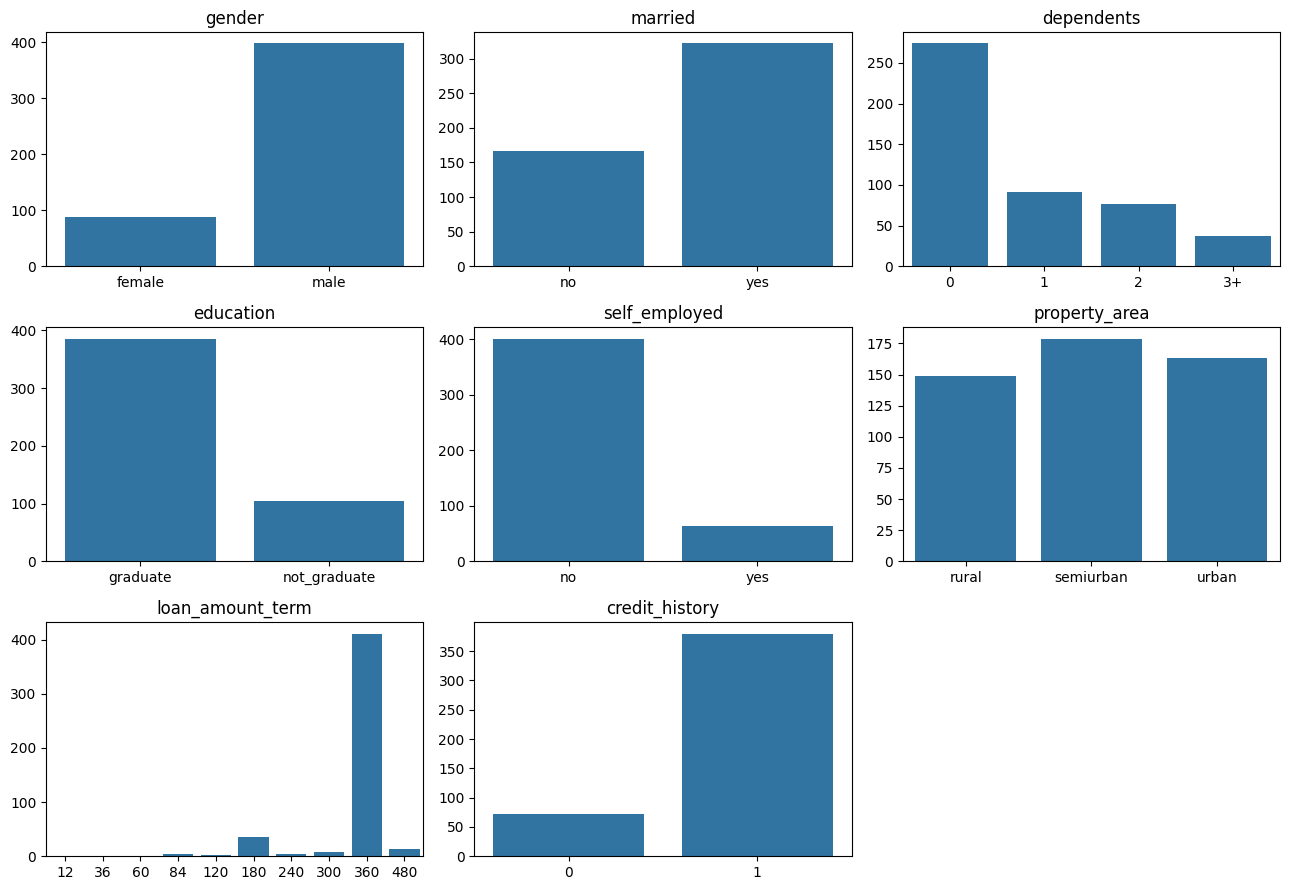

In [44]:
# Countplots
fig, axs = fz.count_viz(df[discrete_cols])
fig

In [46]:
df["loan_amount_term"].value_counts()/len(df["loan_amount_term"])

loan_amount_term
360    0.837067
180    0.071283
480    0.026477
300    0.014257
84     0.008147
240    0.008147
120    0.006110
12     0.002037
36     0.002037
60     0.002037
Name: count, dtype: float64

### Target

In [ ]:
df["loan_status"].describe().T

In [ ]:
plt.pie(
    df["loan_status"].value_counts(),
    labels=df["loan_status"].unique(),
    autopct="%0.2f%%",
    shadow=True,
    explode=(0, 0.1),
    counterclock=False,
    colors=["lime", "cyan"],
)
plt.show()

## Bivariate analysis

### Feature vs. Feature

#### Numerical - Numerical

In [ ]:
# Pairplot
grid = fz.pair_viz(df[continuous_cols])
plt.show()

In [ ]:
# Correlation heatmap
methods = ["pearson", "spearman", "kendall"]
for method in methods:
    fz.corr_heatmap_viz(df[continuous_cols], method=method)
    plt.show()
    print("-" * 150)

#### Categorical - Categorical

In [ ]:
# Crosstab Heatmap
fz.crosstab_heatmap_viz(df, discrete_cols, normalize="both")

#### Numerical - Categorical

##### Box-plot

In [ ]:
# applicant_income
fig, axs = fz.num_cat_viz(df, "applicant_income", discrete_cols)
fig

In [ ]:
# coapplicant_income
fig, axs = fz.num_cat_viz(df, "coapplicant_income", discrete_cols)
fig

In [ ]:
# loan_amount
fig, axs = fz.num_cat_viz(df, "loan_amount", discrete_cols)
fig

##### KDE-plot

In [ ]:
# applicant_income
fig, axs = fz.num_cat_viz(df, "applicant_income", discrete_cols, kind="kde")
fig

In [ ]:
# coapplicant_income
fig, axs = fz.num_cat_viz(df, "coapplicant_income", discrete_cols, kind="kde")
fig

In [ ]:
# loan_amount
fig, axs = fz.num_cat_viz(df, "loan_amount", discrete_cols, kind="kde")
fig

##### Point-plot

In [ ]:
# applicant_income
fig, axs = fz.num_cat_viz(df, "applicant_income", discrete_cols, kind="point")
fig

In [ ]:
# coapplicant_income
fig, axs = fz.num_cat_viz(df, "coapplicant_income", discrete_cols, kind="point")
fig

In [ ]:
# loan_amount
fig, axs = fz.num_cat_viz(df, "loan_amount", discrete_cols, kind="point")
fig

### Feature vs. Target

#### Categorical - Categorical

In [ ]:
# Crosstab Heatmap
fz.crosstab_heatmap_viz(df, discrete_cols, ["loan_status"], "both")

#### Numerical - Categorical

In [ ]:
# Box-plot
fig, axs = fz.num_cat_viz(df, continuous_cols, "loan_status")
fig

In [ ]:
# KDE-plot
fig, axs = fz.num_cat_viz(df, continuous_cols, "loan_status", kind="kde")
fig

In [ ]:
# Point-plot
fig, axs = fz.num_cat_viz(df, continuous_cols, "loan_status", kind="point")
fig

## Mulitvariate analysis

### Feature vs. Feature

#### Numerical - Numerical - Numerical

In [28]:
trace = go.Scatter3d(
    x=df["applicant_income"],
    y=df["coapplicant_income"],
    z=df["loan_amount"],
    mode="markers",
    marker=dict(size=5),
)

layout = go.Layout(
    scene=dict(
        xaxis_title="Applicant Income",
        yaxis_title="Coapplicant Income",
        zaxis_title="Loan Amount",
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### Numerical - Numerical - Categorical

In [ ]:
# Pairplot
for feature in discrete_cols:
    sns.pairplot(df, vars=continuous_cols, hue=feature)
    plt.show()
    print("-" * 105)

In [ ]:
def num_num_cat_viz(x, y, categorical_features):
    for feature in categorical_features:
        sns.relplot(df, x=x, y=y, col=feature)
        plt.show()
        print("-" * 118)

In [ ]:
# applicant_income & coapplicant_income
num_num_cat_viz("applicant_income", "coapplicant_income", discrete_cols)

In [ ]:
# applicant_income & loan_amount
num_num_cat_viz("applicant_income", "loan_amount", discrete_cols)

In [ ]:
# coapplicant_income & loan_amount
num_num_cat_viz("coapplicant_income", "loan_amount", discrete_cols)

#### Numerical - Categorical - Categorical

### Feature vs. Target

#### Numerical - Numerical - Categorical

In [ ]:
sns.pairplot(df, vars=continuous_cols, hue="loan_status")

In [ ]:
def relplot(df, numerical_features, categorical_feature):
    for i, feature_i in enumerate(numerical_features):
        for j, feature_j in enumerate(numerical_features[i + 1 :], start=i + 1):
            sns.relplot(df, x=feature_i, y=feature_j, col=categorical_feature)
            plt.show()
            print("-" * df[categorical_feature].nunique() * 59)

In [ ]:
relplot(df, continuous_cols, "loan_status")

#### Numerical - Categorical - Categorical

# Feature construction

- It looks like people with a co-applicant income of 0 doesn't have a co-applicant. So, we should create a new feature called 'has_coapplicant'. For this feature, set the value to 'no' for individuals with a co-applicant income of 0, and 'yes' for those with a non-zero co-applicant income.

In [ ]:
df["has_coapplicant"] = np.where(df["coapplicant_income"] == 0, "no", "yes")

# Test
df["has_coapplicant"]

In [ ]:
# Appending newly created features based on their feature type
discrete_cols.append("has_coapplicant")

# Test
discrete_cols

# Feature transformation

In [ ]:
transformed_data = fz.feature_transform(df[continuous_cols])

## applicant_income

In [ ]:
# Histogram
fig, axs = fz.feature_transform_viz(df["applicant_income"], transformed_data)
fig

In [ ]:
# QQ Plot
fig, axs = fz.feature_transform_viz(df["applicant_income"], transformed_data, kind="qq")
fig

## coapplicant_income

In [ ]:
# Histogram
fig, axs = fz.feature_transform_viz(df["coapplicant_income"], transformed_data)
fig

In [ ]:
# QQ Plot
fig, axs = fz.feature_transform_viz(
    df["coapplicant_income"], transformed_data, kind="qq"
)
fig

## loan_amount

In [ ]:
# Histogram
fig, axs = fz.feature_transform_viz(df["loan_amount"], transformed_data)
fig

In [ ]:
# QQ Plot
fig, axs = fz.feature_transform_viz(df["loan_amount"], transformed_data, kind="qq")
fig

## Conclusions

- **applicant_income & loan_amount:** Quantile Transform normalizes the data effectively.  
- **coapplicant_income:** Reciprocal Transform transforms coapplicant_income to follow a bimodal distribution.

In [ ]:
df["applicant_income"] = transformed_data["Quantile"]["applicant_income"]
df["coapplicant_income"] = transformed_data["Reciprocal"]["coapplicant_income"]
df["loan_amount"] = transformed_data["Quantile"]["loan_amount"]

In [ ]:
# Test
fig, axs = fz.hist_box_viz(df[continuous_cols])
fig

## Handle Missing Values

### Numerical

In [ ]:
# 1. Handle missing values in categorical columns
cat_imputer = SimpleImputer(strategy="constant", fill_value="missing")
X[discrete_cols] = cat_imputer.fit_transform(X[discrete_cols])

In [ ]:
# OneHotEncoder expects datatypes of every value in a column to be the same
X[discrete_cols] = X[discrete_cols].astype(str)

In [ ]:
# Store encoded feature names before encoding
unique_values_in_cols = {}
for col in discrete_cols:
    encoded_columns = []
    for value in X[col].unique():
        encoded_columns.append(f"{col}_{value}")
    unique_values_in_cols[col] = encoded_columns

In [ ]:
# 2. One-Hot Encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")
encoded_X_data = encoder.fit_transform(X[discrete_cols])
encoded_X_df = pd.DataFrame(encoded_X_data, columns=encoder.get_feature_names_out())

# Concatenating encoded categorical features with the rest of the X
X = pd.concat([X.drop(columns=discrete_cols), encoded_X_df], axis=1)

In [ ]:
# 3. Impute missing values in numerical features using KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

In [ ]:
# 4. Assign the missing value imputed numerical features back to df
df[continuous_cols_with_nan] = X[continuous_cols_with_nan]

### Categorical

In [ ]:
def advanced_categorical_imputer(X, y, clf_model):
    X, y = X.copy(), y.copy()  # Avoid modifying the original X and y

    y_notna = y.notna()  # Create a mask for non-missing values in y

    # Split the data into training (non-missing) and test (missing) data
    X, X_test = X[y_notna], X[~y_notna]
    y_train, y_test = y[y_notna], y[~y_notna]

    # Label encoding the target feature
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

    clf_model.fit(X, y_train)  # Train the model

    y_pred = clf_model.predict(X_test)  # Predict on the test data (missing values)

    # Inverse transform the predicted values to original labels
    y_pred_inverse = le.inverse_transform(y_pred)

    y[y_test.index] = y_pred_inverse  # Impute the missing target values

    return y, clf_model, le

In [ ]:
clf_models = {}
label_encoders = {}
for col in discrete_cols_with_nan:
    df[col], clf_models[col], label_encoders[col] = advanced_categorical_imputer(
        X.drop(columns=unique_values_in_cols[col], errors="ignore"),
        df[col],
        ExtraTreesClassifier(random_state=42),
    )

In [ ]:
def check_missing_values(df):
    if df.isna().any().any():
        print("There are still missing values in the DataFrame.")
    else:
        print("There are no missing values left in the DataFrame.")


# Test
check_missing_values(df)

In [ ]:
# Load the configurations
with open("config/config_v2.toml", "r") as file:
    config_data = toml.load(file)

continuous_cols, discrete_cols = config_data["num"]["cols"], config_data["cat"]["cols"]

# Model Building

In [ ]:
# Split the data into features and target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

In [ ]:
# Label encode target
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# Tranformer for preprocessing data
transformer = make_column_transformer(
    (StandardScaler(), continuous_cols),
    (OneHotEncoder(drop="first", sparse_output=False), discrete_cols),
    remainder="passthrough",
)

In [ ]:
X_transformed = transformer.fit_transform(X)

# Test
X_transformed.shape

## Handling imbalanced dataset

In [ ]:
# Oversampling the dataset using SMOTE
smote = SMOTE(random_state=42)
X_transformed, y_resampled = smote.fit_resample(X_transformed, y)

# Test
print(X_transformed.shape, y_resampled.shape)

In [ ]:
# Test
unique_values, counts = np.unique(y_resampled, return_counts=True)

# Print the counts of each class
for value, count in zip(unique_values, counts):
    print(f"Class {value}: {count}")

## Model selection (Before hyperparameter tuning)

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Trees": DecisionTreeClassifier(),
    "Xgboost": XGBClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
}

In [ ]:
# Define metric functions
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score,
}

In [ ]:
def eval_models_across_metrics(models, metrics, X, y, cv=5):
    models_across_metrics = {metric: {} for metric in metrics}
    for metric in metrics:
        for model_name, model in models.items():
            cv_scores = cross_val_score(model, X, y, cv=cv, scoring=metric)
            cv_scores_mean = cv_scores.mean()
            models_across_metrics[metric][model_name] = round(cv_scores_mean, 3)
    return pd.DataFrame(models_across_metrics)

In [ ]:
models_across_metrics = eval_models_across_metrics(
    models, metrics.keys(), X_transformed, y_resampled
)

In [ ]:
models_across_metrics

Conclusions:

- After evaluating the metrics, I have decided to focus on the top 3 models (in terms of accuracy_score): Random Forest Classifier, Extra Trees Classifier, Xgboost Classifier.

## Hyperparameter tuning

In [ ]:
# Define top models for further hyperparameter tuning
models = {
    "Random Forest": RandomForestClassifier(),
    "Xgboost": XGBClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
}

In [ ]:
# Split the dataset into features and target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

In [ ]:
# Define parameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 200],
        "max_depth": [None, 30],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 4],
    },
    "Xgboost": {
        "n_estimators": [50, 200],
        "max_depth": [3, 10],
        "learning_rate": [0.01, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 0.2],
    },
    "Extra Trees": {
        "n_estimators": [50, 200],
        "max_depth": [None, 30],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 4],
        "bootstrap": [True, False],
    },
}

In [ ]:
def perform_grid_search(models, param_grids, X, y):
    best_params = {}
    for model_name, model in models.items():
        print(f"Processing {model_name}...")
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="accuracy",
            cv=5,
            n_jobs=-1,
            verbose=1,
        )
        grid_search.fit(X, y)
        best_params[model_name] = {
            "Best Parameters": grid_search.best_params_,
            "Average accuracy score on the best parameters": round(
                grid_search.best_score_, 3
            ),
        }
    return best_params

In [ ]:
# Finding best hyperparameters on top models using GridSearchCV
best_params = perform_grid_search(models, param_grids, X_transformed, y_resampled)

In [ ]:
pd.DataFrame(best_params)

In [ ]:
# best_params

# {'Random Forest': {'Best Parameters': {'max_depth': None,
#    'min_samples_leaf': 1,
#    'min_samples_split': 2,
#    'n_estimators': 200},
#   'Average accuracy score on the best parameters': 0.838},
#  'Xgboost': {'Best Parameters': {'colsample_bytree': 0.8,
#    'gamma': 0.2,
#    'learning_rate': 0.2,
#    'max_depth': 10,
#    'n_estimators': 50,
#    'subsample': 1.0},
#   'Average accuracy score on the best parameters': 0.826},
#  'Extra Trees': {'Best Parameters': {'bootstrap': True,
#    'max_depth': 30,
#    'min_samples_leaf': 1,
#    'min_samples_split': 2,
#    'n_estimators': 200},
#   'Average accuracy score on the best parameters': 0.84}}

In [ ]:
# Define top models with best hyperparameters
models = {
    "Random Forest": RandomForestClassifier(
        **best_params["Random Forest"]["Best Parameters"]
    ),
    "Xgboost": XGBClassifier(**best_params["Xgboost"]["Best Parameters"]),
    "Extra Trees": ExtraTreesClassifier(
        **best_params["Extra Trees"]["Best Parameters"]
    ),
}

In [ ]:
# Comparing top models across metrics after hyperparameter tuning
models_across_metrics = eval_models_across_metrics(
    models, metrics.keys(), X_transformed, y_resampled
)

In [ ]:
models_across_metrics


## Model training


In [ ]:
estimators = []
for model_name, model in models.items():
    estimators.append((model_name, model))

In [ ]:
estimators

In [ ]:
def eval_voting_clf(estimators, X, y, cv=5):
    # Create a voting classifier (hard voting)
    voting_clf_hard = VotingClassifier(estimators=estimators, voting="hard")

    # Create a voting classifier (soft voting)
    voting_clf_soft = VotingClassifier(estimators=estimators, voting="soft")

    # Apply cross-validation
    cv_scores_h = cross_val_score(voting_clf_hard, X, y, cv=cv, scoring="accuracy")
    cv_scores_s = cross_val_score(voting_clf_soft, X, y, cv=cv, scoring="accuracy")

    accuracy_results = {}

    accuracy_results["Hard Margin"] = round(cv_scores_h.mean(), 3)
    accuracy_results["Soft Margin"] = round(cv_scores_s.mean(), 3)

    return accuracy_results

In [ ]:
# Accuracy on hard and soft margin voting classifiers
accuracy = eval_voting_clf(estimators, X_transformed, y_resampled)
accuracy

In [ ]:
# Fit the best model
voting_clf = VotingClassifier(estimators, voting="hard")
voting_clf.fit(X_transformed, y_resampled)

In [ ]:
# Create a pipeline
pipeline = make_pipeline(
    StandardScaler(),  # Step 1: Standardize the data
    PCA(n_components=2),  # Step 2: Apply PCA
    LogisticRegression(),  # Step 3: Train a logistic regression model
)

In [ ]:
# Reorder columns
target_col = "loan_status"
df = df[continuous_cols + discrete_cols + [target_col]]

# Test
df.columns

In [ ]:
# Pipeline
pipe = make_pipeline((transformer), ("model", voting_clf))

pipe.fit(X, y)

## Saving

In [ ]:
# Save the Machine Learning model
joblib.dump(voting_clf, "model.joblib")

In [ ]:
# Statistical measures
df[["has_coapplicant"]].describe().T

# Countplot
sns.countplot(x=df["has_coapplicant"])
plt.show()

# Heatmap
fz.crosstab_heatmap_viz(df, ["loan_status"], ["has_coapplicant"], "both")

# Heatmap
fz.crosstab_heatmap_viz(df, discrete_cols, ["has_coapplicant"], "both")

# Point plot
fig, axs = fz.num_cat_viz(df, continuous_cols, "has_coapplicant", kind="point")
fig

In [ ]:
# Export config data
config_data = {
    "column_names": column_names,
    "num": {"cols": continuous_cols, "nan": continuous_cols_with_nan},
    "cat": {"cols": discrete_cols, "nan": discrete_cols_with_nan},
    "target_col": target_col,
}

with open("src/loan_sanction_prediction/config.yaml", "w") as file:
    yaml.dump(config_data, file, default_flow_style=False)

# Export dataset
fz.export(df, "../data/interim/cleaned_train_data_v1.csv", force_overwrite=True)

In [ ]:
log.info("Format columns...")
try:
    df = df[continuous_cols + discrete_cols + target_col]
    log.success(f"Successfully formatted columns: {df.columns.to_list()}")
except Exception:
    log.exception("Failed to format columns")
    raise